## 导入Python包

In [1]:
import time
import torch
import torchvision
import torchmetrics
from hyperopt import hp
from torch.utils import data
from torchvision import transforms
import matplotlib.pyplot as plt
from IPython import display
from matplotlib_inline import backend_inline
import numpy as np
import ray.tune
import os

## code from d2l

In [2]:
def use_svg_display():
    backend_inline.set_matplotlib_formats('svg')


def set_figsize(figsize=(3.5, 2.5)):
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴

    Defined in :numref:`sec_calculus`"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """绘制数据点

    Defined in :numref:`sec_calculus`"""
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else plt.gca()

    # 如果X有一个轴，输出True
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

DATA_PATH = './data'

def get_dataloader_workers():
    """使用4个进程来读取数据

    Defined in :numref:`sec_fashion_mnist`"""
    return os.cpu_count()

def try_gpu(i=0):
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

def load_data_fashion_mnist(batch_size, resize=None):
    """下载Fashion-MNIST数据集，然后将其加载到内存中

    Defined in :numref:`sec_fashion_mnist`"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root=DATA_PATH, train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root=DATA_PATH, train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """绘制图像列表

    Defined in :numref:`sec_fashion_mnist`"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

def accuracy(y_hat, y):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        """Defined in :numref:`sec_softmax_scratch`"""
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_softmax_scratch`"""
        # 增量地绘制多条线
        if legend is None:
            legend = []
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts
    
    def add(self, x, y):
        # 这一部分的目的是，序列化输入x，y
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        # 初始化主类的数据存储
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        # 逐一添加数据
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        # 依次画线，此处应当注意x，y的线的数量超过fmts的长度时，应当自定义self.fmts
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

class Timer:
    """记录多次运行时间"""
    def __init__(self):
        """Defined in :numref:`subsec_linear_model`"""
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

def evaluate_accuracy_gpu(net, data_iter, device=None): #@save
    """使用GPU计算模型在数据集上的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 设置为评估模式
        if not device:
            device = next(iter(net.parameters())).device
    # 正确预测的数量，总预测的数量
    metric = Accumulator(2)#创建一个累加器，包含2个要累加的元素
    with torch.no_grad():
        for X, y in data_iter:
            if isinstance(X, list):
                # BERT微调所需的（之后将介绍）
                X = [x.to(device) for x in X]
            else:
                X = X.to(device)
            y = y.to(device)
            metric.add(accuracy(net(X), y), y.numel())#把每一组数据预测结果正确的个数和长度累加
    return metric[0] / metric[1]

def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型(在第六章定义)

    Defined in :numref:`sec_lenet`"""
    def init_weights(m):
        if type(m) == torch.nn.Linear or type(m) == torch.nn.Conv2d:
            torch.nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = torch.nn.CrossEntropyLoss()
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss {train_l:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec '
          f'on {str(device)}')



## homework code in ch7 sec1

In [3]:
batch_size = 128
lr, num_epochs = 0.01, 15

loss 0.257, train acc 0.903, test acc 0.875
22329.3 examples/sec on cuda:0


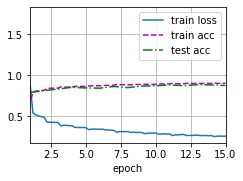

In [11]:
# T1
lenet = torch.nn.Sequential(
    torch.nn.Conv2d(1, 6, kernel_size=5, padding=2), torch.nn.ReLU(),
    torch.nn.AvgPool2d(kernel_size=2, stride=2),
    torch.nn.Conv2d(6, 16, kernel_size=5), torch.nn.ReLU(),
    torch.nn.AvgPool2d(kernel_size=2, stride=2),
    torch.nn.Flatten(),
    torch.nn.Linear(16 * 5 * 5, 120), torch.nn.ReLU(),
    torch.nn.Linear(120, 84), torch.nn.ReLU(),
    torch.nn.Linear(84, 10))

lenet = torch.nn.DataParallel(lenet)
train_iter, test_iter = load_data_fashion_mnist(batch_size)
train_ch6(lenet, train_iter, test_iter, num_epochs, 0.1, try_gpu())
torch.cuda.empty_cache()

loss 0.165, train acc 0.939, test acc 0.916
787.0 examples/sec on cuda:0


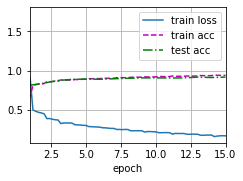

In [8]:
alexnet = torch.nn.Sequential(
    torch.nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=3, stride=2),
    torch.nn.Conv2d(96, 256, kernel_size=5, padding=2), torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=3, stride=2),
    torch.nn.Conv2d(256, 384, kernel_size=3, padding=1), torch.nn.ReLU(),
    torch.nn.Conv2d(384, 384, kernel_size=3, padding=1), torch.nn.ReLU(),
    torch.nn.Conv2d(384, 256, kernel_size=3, padding=1), torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=3, stride=2),
    torch.nn.Flatten(),
    torch.nn.Linear(6400, 4096), torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(4096, 4096), torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(4096, 10))

alexnet = torch.nn.DataParallel(alexnet)
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=224)
train_ch6(alexnet, train_iter, test_iter, num_epochs, 0.05, try_gpu())
torch.cuda.empty_cache()

loss 0.228, train acc 0.915, test acc 0.912
6290.6 examples/sec on cuda:0
gpu_usage: 420.18 MB


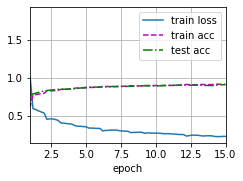

In [11]:
#T2 T3
alexnet_v2 = torch.nn.Sequential(
    torch.nn.Conv2d(1, 96, kernel_size=5, padding=2), torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=3, stride=2),
    torch.nn.Conv2d(96, 144, kernel_size=3, padding=1), torch.nn.ReLU(),
    torch.nn.Conv2d(144, 144, kernel_size=3, padding=1), torch.nn.ReLU(),
    torch.nn.Conv2d(144, 96, kernel_size=3, padding=1), torch.nn.ReLU(),
    torch.nn.MaxPool2d(kernel_size=3, stride=2),
    torch.nn.Flatten(),
    torch.nn.Linear(96*6*6, 1024), torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(1024, 1024), torch.nn.ReLU(),
    torch.nn.Dropout(p=0.5),
    torch.nn.Linear(1024, 10))

alexnet_v2 = torch.nn.DataParallel(alexnet_v2)
train_iter, test_iter = load_data_fashion_mnist(batch_size)
train_ch6(alexnet_v2, train_iter, test_iter, num_epochs, 0.05, try_gpu())
print(f'gpu_usage: {torch.cuda.memory_allocated()/(1024*1024):5.5} MB')
torch.cuda.empty_cache()

loss 0.385, train acc 0.865, test acc 0.872
22101.4 examples/sec on cuda:0


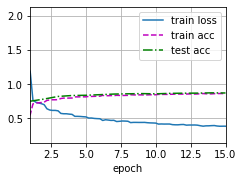

In [12]:
# T5
lenet_v2 = torch.nn.Sequential(
    torch.nn.Conv2d(1, 6, kernel_size=5, padding=2), torch.nn.ReLU(),
    torch.nn.AvgPool2d(kernel_size=2, stride=2),
    torch.nn.Conv2d(6, 16, kernel_size=5), torch.nn.ReLU(),
    torch.nn.AvgPool2d(kernel_size=2, stride=2),
    torch.nn.Flatten(),
    torch.nn.Linear(16 * 5 * 5, 120), torch.nn.ReLU(), torch.nn.Dropout(0.5),
    torch.nn.Linear(120, 84), torch.nn.ReLU(), torch.nn.Dropout(0.5),
    torch.nn.Linear(84, 10))

lenet_v2 = torch.nn.DataParallel(lenet_v2)
train_iter, test_iter = load_data_fashion_mnist(batch_size)
train_ch6(lenet_v2, train_iter, test_iter, num_epochs, 0.1, try_gpu())
torch.cuda.empty_cache()

## homework code in ch7 sec2

In [24]:
class vgg_block(torch.nn.Module):
    def __init__(self, num_layer, in_channel, out_channel):
        super().__init__()
        self.vgg_block = torch.nn.Sequential()
        in_channel = in_channel
        for _ in range(num_layer):
            self.vgg_block.append(torch.nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1))
            self.vgg_block.append(torch.nn.ReLU())
            in_channel = out_channel
        self.vgg_block.append(torch.nn.MaxPool2d(kernel_size=2, stride=2))
            
    def forward(self, x):
        return self.vgg_block(x)

class vgg_net(torch.nn.Module):
    def __init__(self, layers, out_channels, in_channels=1, input_shape=[1, 224, 224]):
        super().__init__()
        height, width = input_shape[1], input_shape[2]
        in_channel = in_channels
        self.conv_part = torch.nn.Sequential()
        for layer, out_channel in zip(layers, out_channels):
            self.conv_part.append(vgg_block(layer, in_channel, out_channel))
            in_channel = out_channel
            height, width = height // 2, width // 2
        self.fc_part = torch.nn.Sequential(torch.nn.Flatten(), 
                                            torch.nn.Linear(in_channel*height*width, 4096), torch.nn.ReLU(),torch.nn.Dropout(0.5),
                                            torch.nn.Linear(4096, 4096), torch.nn.ReLU(),torch.nn.Dropout(0.5),
                                            torch.nn.Linear(4096, 10))
    
    def forward(self, x):
        x = self.conv_part(x)
        return self.fc_part(x)

loss 0.172, train acc 0.936, test acc 0.919
211.5 examples/sec on cuda:0
gpu_usage: 1025.5 MB


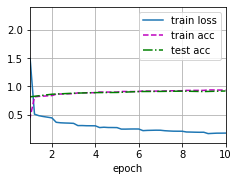

In [26]:
# vgg-16 ((2, 64), (2, 128), (3, 256), (3, 512), (3, 512))
# vgg-19 ((2, 64), (2, 128), (4, 256), (4, 512), (4, 512))
vgg_16 = vgg_net((2,2,3,3,3), (64, 128, 256, 512, 512))
vgg_16 = torch.nn.DataParallel(vgg_16)
train_iter, test_iter = load_data_fashion_mnist(batch_size, 224)
train_ch6(vgg_16, train_iter, test_iter, num_epochs-5, 0.05, try_gpu())
print(f'gpu_usage: {torch.cuda.memory_allocated()/(1024*1024):5.5} MB')
torch.cuda.empty_cache()

loss 0.239, train acc 0.912, test acc 0.911
195.2 examples/sec on cuda:0
gpu_usage: 2092.5 MB


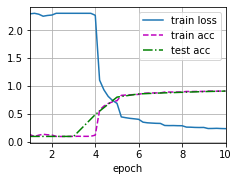

In [28]:
vgg_19 = vgg_net((2,2,4,4,4), (64, 128, 256, 512, 512))
vgg_19 = torch.nn.DataParallel(vgg_19)
train_ch6(vgg_19, train_iter, test_iter, num_epochs-5, 0.05, try_gpu())
print(f'gpu_usage: {torch.cuda.memory_allocated()/(1024*1024):5.5} MB')
torch.cuda.empty_cache()

## homework code ch7 sec3

In [4]:
class nin_block(torch.nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, strides, padding) -> None:
        super().__init__()
        self.nin_block = torch.nn.Sequential(torch.nn.Conv2d(in_channel, out_channel, kernel_size, strides, padding), torch.nn.ReLU())
        for _ in range(2):
            self.nin_block.append(torch.nn.Conv2d(out_channel, out_channel, 1))
            self.nin_block.append(torch.nn.ReLU())
        
    def forward(self, x):
        return self.nin_block(x)

class nin_net(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_sizes, 
                strideses, paddings, dropout_rates) -> None:
        super().__init__()
        self.nin_layer = torch.nn.Sequential()
        for i, (in_channel, out_channel, kernel_size, \
            strides, dropout_rate, padding) in enumerate(zip(in_channels, out_channels, 
                                                  kernel_sizes, strideses, dropout_rates, paddings)):
            if i > 0:
                self.nin_layer.append(torch.nn.MaxPool2d(3, 2))
                if dropout_rate > 0:
                    self.nin_layer.append(torch.nn.Dropout(dropout_rate))
            self.nin_layer.append(nin_block(in_channel, out_channel, kernel_size, strides, padding))
        self.nin_layer.append(torch.nn.AdaptiveAvgPool2d((1, 1)))
        self.nin_layer.append(torch.nn.Flatten())
    
    def forward(self, x):
        return self.nin_layer(x)

class nin_block_v2(torch.nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, strides, padding) -> None:
        super().__init__()
        self.nin_block = torch.nn.Sequential(torch.nn.Conv2d(in_channel, out_channel, kernel_size, strides, padding), torch.nn.ReLU())
        self.nin_block.append(torch.nn.Conv2d(out_channel, out_channel, 1))
        self.nin_block.append(torch.nn.ReLU())
        
    def forward(self, x):
        return self.nin_block(x)

class nin_net_v2(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_sizes, 
                strideses, paddings, dropout_rates) -> None:
        super().__init__()
        self.nin_layer = torch.nn.Sequential()
        for i, (in_channel, out_channel, kernel_size, \
            strides, dropout_rate, padding) in enumerate(zip(in_channels, out_channels, 
                                                  kernel_sizes, strideses, dropout_rates, paddings)):
            if i > 0:
                self.nin_layer.append(torch.nn.MaxPool2d(3, 2))
                if dropout_rate > 0:
                    self.nin_layer.append(torch.nn.Dropout(dropout_rate))
            self.nin_layer.append(nin_block_v2(in_channel, out_channel, kernel_size, strides, padding))
        self.nin_layer.append(torch.nn.AdaptiveAvgPool2d((1, 1)))
        self.nin_layer.append(torch.nn.Flatten())
    
    def forward(self, x):
        return self.nin_layer(x)

In [ ]:
#T1


loss 0.266, train acc 0.903, test acc 0.887
3264.7 examples/sec on cuda:0
gpu_usage: 14.282 MB


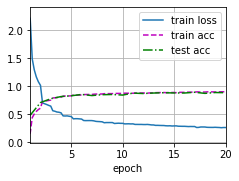

In [10]:
# T2
inner_node = (96, 256, 384)
nin_v2 = nin_net_v2((1,)+inner_node, inner_node+(10,), (11, 5, 3, 3), (4, 1, 1, 1), (0,2,1,1),(0,0,0,0.5))
nin_v2 = torch.nn.DataParallel(nin_v2)
train_ch6(nin_v2, train_iter, test_iter, num_epochs+5, 0.05, try_gpu())
print(f'gpu_usage: {torch.cuda.memory_allocated()/(1024*1024):5.5} MB')
torch.cuda.empty_cache()

## homework code ch7 sec4

In [21]:
#T1
class Inception(torch.nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4, is_batch=False, **kwargs):
        super(Inception, self).__init__(**kwargs)
        self.p1 = torch.nn.Sequential(torch.nn.Conv2d(in_channels, c1, kernel_size=1))
        self.p2 = torch.nn.Sequential(torch.nn.Conv2d(in_channels, c2[0], kernel_size=1), torch.nn.ReLU(),
                                        torch.nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1))
        self.p3 = torch.nn.Sequential(torch.nn.Conv2d(in_channels, c3[0], kernel_size=1), torch.nn.ReLU(),
                                        torch.nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2))
        self.p4 = torch.nn.Sequential(torch.nn.MaxPool2d(kernel_size=3, stride=1, padding=1), torch.nn.ReLU(),
                                        torch.nn.Conv2d(in_channels, c4, kernel_size=1))
        self.ends = torch.nn.Sequential(torch.nn.BatchNorm2d(c1+c2[1]+c3[1]+c4), torch.nn.ReLU()) if is_batch else torch.nn.ReLU()

    def forward(self, x):
        p1 = self.p1(x)
        p2 = self.p2(x)
        p3 = self.p3(x)
        p4 = self.p4(x)
        return self.ends(torch.cat((p1, p2, p3, p4), dim=1))

def Inception_block(in_channels, c1s, c2s, c3s, c4s, is_batchs):
    block = torch.nn.Sequential(torch.nn.MaxPool2d(3, 2, 1))
    in_channel = in_channels
    for c1, c2, c3, c4, is_batch in zip(c1s, c2s, c3s, c4s, is_batchs):
        block.append(Inception(in_channel, c1, c2, c3, c4, is_batch))
        in_channel = c1 + c2[1] + c3[1] + c4
    return block

class GoogleNet(torch.nn.Module):
    def __init__(self, c1s, c2s, c3s, c4s, is_batchs, in_channel=1) -> None:
        super().__init__()
        input_channel = in_channel
        self.start_cnn = torch.nn.Sequential(torch.nn.Conv2d(input_channel, 64, 7, 2, 3), torch.nn.ReLU(),
                                            torch.nn.MaxPool2d(3, 2, 1), torch.nn.Conv2d(64, 64, 1), torch.nn.ReLU(),
                                            torch.nn.Conv2d(64, 192, 3, 1))
        input_channel = 192
        self.inception_block = torch.nn.Sequential()
        for c1, c2, c3, c4, is_batch in zip(c1s, c2s, c3s, c4s, is_batchs):
            self.inception_block.append(Inception_block(input_channel, c1, c2, c3, c4, is_batch))
            input_channel = c1[-1] + c2[-1][1] + c3[-1][1] + c4[-1]
        self.fc_layer = torch.nn.Sequential(torch.nn.AdaptiveAvgPool2d((1, 1)), torch.nn.Flatten(),
                                            torch.nn.Dropout(0.4), torch.nn.Linear(input_channel, 10))
    
    def forward(self, x):
        x = self.start_cnn(x)
        x = self.inception_block(x)
        x = self.fc_layer(x)
        return x


loss 0.057, train acc 0.979, test acc 0.919
1233.1 examples/sec on cuda:0
gpu_usage: 62.636 MB


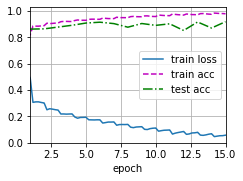

In [23]:
v1 = GoogleNet(
                ((64, 128), (192, 160, 128, 112, 256), (256, 384)), 
                (((96, 128), (128, 192)), ((96, 208), (112, 224), (128, 256), (144, 288), (160, 320)), ((160, 320), (192, 384))), 
                (((16, 32), (32, 96)), ((16, 48), (24, 64), (24, 64), (32, 64), (32, 128)), ((32, 128), (48, 128))), 
                ((32, 64), (64, 64, 64, 64, 128), (128, 128)),
                ((1, 1), (1, 1, 1, 1, 1), (1, 1)))
v1 = torch.nn.DataParallel(v1)
train_iter, test_iter = load_data_fashion_mnist(batch_size, 224)
train_ch6(v1, train_iter, test_iter, num_epochs, 0.05, try_gpu())
print(f'gpu_usage: {torch.cuda.memory_allocated()/(1024*1024):5.5} MB')
torch.cuda.empty_cache()

## homework code ch7 sec 5

loss 0.165, train acc 0.939, test acc 0.904
18720.6 examples/sec on cuda:0


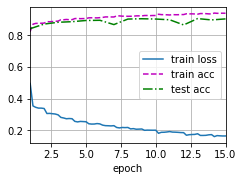

In [15]:
#T2
lenet_v3 = torch.nn.Sequential(
    torch.nn.Conv2d(1, 6, kernel_size=5, padding=2), torch.nn.BatchNorm2d(6), torch.nn.ReLU(),
    torch.nn.AvgPool2d(kernel_size=2, stride=2),
    torch.nn.Conv2d(6, 16, kernel_size=5), torch.nn.BatchNorm2d(16), torch.nn.ReLU(),
    torch.nn.AvgPool2d(kernel_size=2, stride=2),
    torch.nn.Flatten(),
    torch.nn.Linear(16 * 5 * 5, 120), torch.nn.BatchNorm1d(120), torch.nn.ReLU(),
    torch.nn.Linear(120, 84), torch.nn.BatchNorm1d(84), torch.nn.ReLU(),
    torch.nn.Linear(84, 10))

lenet_v3 = torch.nn.DataParallel(lenet_v3)
train_iter, test_iter = load_data_fashion_mnist(batch_size)
train_ch6(lenet_v3, train_iter, test_iter, num_epochs, 0.1, try_gpu())
torch.cuda.empty_cache()

loss 0.191, train acc 0.929, test acc 0.896
20095.3 examples/sec on cuda:0


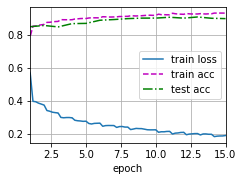

In [16]:
#T3
lenet_v4 = torch.nn.Sequential(
    torch.nn.Conv2d(1, 6, kernel_size=5, padding=2), torch.nn.BatchNorm2d(6), torch.nn.ReLU(),
    torch.nn.AvgPool2d(kernel_size=2, stride=2),
    torch.nn.Conv2d(6, 16, kernel_size=5), torch.nn.BatchNorm2d(16), torch.nn.ReLU(),
    torch.nn.AvgPool2d(kernel_size=2, stride=2),
    torch.nn.Flatten(),
    torch.nn.Linear(16 * 5 * 5, 120), torch.nn.ReLU(),
    torch.nn.Linear(120, 84), torch.nn.ReLU(),
    torch.nn.Linear(84, 10))

lenet_v4 = torch.nn.DataParallel(lenet_v4)
train_ch6(lenet_v4, train_iter, test_iter, num_epochs, 0.1, try_gpu())
torch.cuda.empty_cache()

loss 0.180, train acc 0.933, test acc 0.907
20145.6 examples/sec on cuda:0


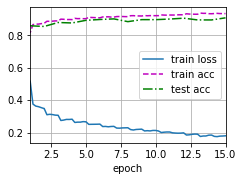

In [17]:
lenet_v5 = torch.nn.Sequential(
    torch.nn.Conv2d(1, 6, kernel_size=5, padding=2), torch.nn.ReLU(),
    torch.nn.AvgPool2d(kernel_size=2, stride=2),
    torch.nn.Conv2d(6, 16, kernel_size=5), torch.nn.ReLU(),
    torch.nn.AvgPool2d(kernel_size=2, stride=2),
    torch.nn.Flatten(),
    torch.nn.Linear(16 * 5 * 5, 120), torch.nn.BatchNorm1d(120), torch.nn.ReLU(),
    torch.nn.Linear(120, 84), torch.nn.BatchNorm1d(84), torch.nn.ReLU(),
    torch.nn.Linear(84, 10))

lenet_v5 = torch.nn.DataParallel(lenet_v5)
train_iter, test_iter = load_data_fashion_mnist(batch_size)
train_ch6(lenet_v5, train_iter, test_iter, num_epochs, 0.1, try_gpu())
torch.cuda.empty_cache()

## homework ch7 sec6

In [41]:
#T2, T3, T4
class Residual(torch.nn.Module):
    def __init__(self, in_filter, out_filter, stride, activation=torch.nn.ReLU) -> None:
        super().__init__()
        self.bottle = torch.nn.Sequential(
                                        torch.nn.BatchNorm2d(in_filter), activation(),
                                        torch.nn.Conv2d(in_filter, out_filter, 3, stride, 1, bias=False),
                                        torch.nn.BatchNorm2d(filter), activation(),
                                        torch.nn.Conv2d(out_filter, out_filter, 3, 1, bias=False))
        self.residual = torch.nn.Sequential()
        if in_filter != out_filter:
            self.residual.append(torch.nn.Conv2d(in_filter, out_filter, 1, stride))

    def forward(self, x):
        return torch.add(self.bottle(x), self.residual(x))


class Bottleneck(torch.nn.Module):
    def __init__(self, in_filter, out_filter, stride, activation=torch.nn.ReLU) -> None:
        super().__init__()
        filter = out_filter // 4
        self.bottle = torch.nn.Sequential(torch.nn.BatchNorm2d(in_filter), activation(),
                                        torch.nn.Conv2d(in_filter, filter, 1, 1, bias=False),
                                        torch.nn.BatchNorm2d(filter), activation(),
                                        torch.nn.Conv2d(filter, filter, 3, stride, 1, bias=False),
                                        torch.nn.BatchNorm2d(filter), activation(),
                                        torch.nn.Conv2d(filter, out_filter, 1, 1, bias=False))
        self.residual = torch.nn.Sequential()
        if in_filter != out_filter:
            self.residual.append(torch.nn.Conv2d(in_filter, out_filter, 1, stride))

    def forward(self, x):
        return torch.add(self.bottle(x), self.residual(x))


class ResNet_v2(torch.nn.Module):
    def __init__(self, filters, block, activation=torch.nn.ReLU, input_channel=1, out_shape=10) -> None:
        super().__init__()
        init_filter = input_channel
        self.resnet = torch.nn.Sequential(torch.nn.Conv2d(init_filter, 64, 7, 2, padding=3, bias=False), 
                                            torch.nn.BatchNorm2d(64), torch.nn.ReLU(),
                                            torch.nn.MaxPool2d(3,2,1))
        init_filter = 64
        for i, filter in enumerate(filters):
            stride = 1 if filter == init_filter or i == 0 else 2
            self.resnet.append(block(init_filter, filter, stride, activation))
            init_filter = filter
        self.fc_layer = torch.nn.Sequential(torch.nn.AdaptiveAvgPool2d((1, 1)), torch.nn.Flatten(),
                        torch.nn.Linear(init_filter, out_shape))
    
    def forward(self, x):
        x = self.resnet(x)
        return self.fc_layer(x)


loss 0.110, train acc 0.959, test acc 0.909
2033.3 examples/sec on cuda:0
gpu_usage: 95.685 MB


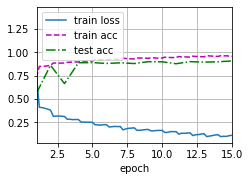

In [51]:
# 原网络最后一层输出2048， 这里考虑到信息瓶颈2048->10的问题，将结点数进行了减少。
resnet_50 = ResNet_v2((32,)*3+(64,)*4+(128,)*6+(256,)*3, block=Bottleneck)
resnet_50 = torch.nn.DataParallel(resnet_50)
train_iter, test_iter = load_data_fashion_mnist(batch_size, 224)
train_ch6(resnet_50, train_iter, test_iter, num_epochs-5, 0.1, try_gpu())
print(f'gpu_usage: {torch.cuda.memory_allocated()/(1024*1024):5.5} MB')
torch.cuda.empty_cache()

In [ ]:
#T2
#resnet_18 = ResNet_v2((64,)*2+(128,)*2+(256,)*2+(512,)*2, block=Residual)
#resnet_36 = ResNet_v2((64,)*3+(128,)*4+(256,)*6+(512,)*3, block=Residual)
#resnet_50 = ResNet_v2((256,)*3+(512,)*4+(1024,)*6+(2048,)*3, block=Bottleneck)
#resnet_101 = ResNet_v2((256,)*3+(512,)*4+(1024,)*23+(2048,)*3, block=Bottleneck)
#resnet_152 = ResNet_v2((256,)*3+(512,)*8+(1024,)*36+(2048,)*3, block=Bottleneck)


# homework ch7 sec 7

In [52]:
def conv_block(input_channels, num_channels):
    return torch.nn.Sequential(
    torch.nn.BatchNorm2d(input_channels), torch.nn.ReLU(),
    torch.nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1))

class DenseBlock(torch.nn.Module):
    def __init__(self, num_convs, input_channels, num_channels, drop_rate):
        super().__init__()
        self.block = torch.nn.Sequential(*[conv_block(num_channels * i + input_channels, num_channels) for i in range(num_convs)])
        self.drop = torch.nn.Dropout(p=drop_rate)
        
    def forward(self, x):
        for blk in self.block:
            y = blk(x)
            y = self.drop(y)
            x = torch.cat((x, y), dim=1)
        return x

def TransitionBlock(input_channels, num_channels):
    return torch.nn.Sequential(
            torch.nn.BatchNorm2d(input_channels), torch.nn.ReLU(),
            torch.nn.Conv2d(input_channels, num_channels, kernel_size=1),
            torch.nn.AvgPool2d(kernel_size=2, stride=2))

class DenseNet(torch.nn.Module):
    def __init__(self, growth_rate, block_config, num_init_feature=64, input_channel=1,
                    bn_size=4, drop_rate=0.5, num_class=10) -> None:
        super().__init__()
        self.convpart = torch.nn.Sequential(torch.nn.Conv2d(input_channel, num_init_feature, 7, 2, padding=3, bias=False), 
                                            torch.nn.BatchNorm2d(64), torch.nn.ReLU(),
                                            torch.nn.MaxPool2d(3,2,1))
        num_feature = num_init_feature
        self.densepart = torch.nn.Sequential()
        for i, num_layer in enumerate(block_config):
            self.densepart.append(DenseBlock(num_layer, num_feature, growth_rate, drop_rate))
            num_feature += growth_rate*num_layer
            if i != len(block_config):
                self.densepart.append(TransitionBlock(num_feature, num_feature//2))
                num_feature //= 2
        self.fc_layer = torch.nn.Sequential(torch.nn.BatchNorm2d(num_feature), torch.nn.ReLU(),
                        torch.nn.AdaptiveAvgPool2d((1, 1)), torch.nn.Flatten(),
                        torch.nn.Linear(num_feature, num_class))
    
    def forward(self, x):
        x = self.convpart(x)
        x = self.densepart(x)
        x = self.fc_layer(x)
        return x

In [53]:
test = DenseNet(32, (6, 12, 24, 16))
x = torch.rand(1, 1, 224, 224)
test(x)

tensor([[-0.3285,  0.0955,  0.3279,  0.0486,  0.0717,  0.0013, -0.5254,  0.3822,
         -0.0375,  0.1273]], grad_fn=<AddmmBackward0>)

loss 0.179, train acc 0.935, test acc 0.904
565.6 examples/sec on cuda:0
gpu_usage: 176.58 MB


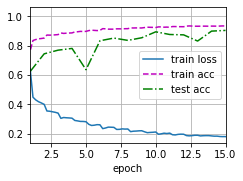

In [54]:
densenet = DenseNet(32, (6, 12, 24, 16))
densenet = torch.nn.DataParallel(densenet)
train_iter, test_iter = load_data_fashion_mnist(batch_size, 224)
train_ch6(densenet, train_iter, test_iter, num_epochs, 0.1, try_gpu())
print(f'gpu_usage: {torch.cuda.memory_allocated()/(1024*1024):5.5} MB')
torch.cuda.empty_cache()

In [ ]:
#T4
#densenet_121 = DenseNet(32, (6, 12, 24, 16))
#densenet_169 = DenseNet(32, (6, 12, 32, 32))
#densenet_201 = DenseNet(32, (6, 12, 48, 32))
#densenet_264 = DenseNet(32, (6, 12, 64, 48))